In [1]:
%matplotlib inline
import pandas as pd

In [21]:
osm_routepoints = pd.read_csv("../data/osm_routepoints.csv", dtype=str)
for c in osm_routepoints.columns:
    new_col = "osm_" + c
    osm_routepoints.rename(columns={c: new_col}, inplace=True)

gtfs_routepoints = pd.read_csv("../data/gtfs_routepoints.csv", dtype=str)
for c in gtfs_routepoints.columns:
    new_col = "gtfs_" + c
    gtfs_routepoints.rename(columns={c: new_col}, inplace=True)
    
gtfs_routepoints.fillna("", inplace=True)
gtfs_routepoints = gtfs_routepoints[gtfs_routepoints['gtfs_ZDEr_ID_REF_A'] != '']

routepoints = gtfs_routepoints.merge(
                    osm_routepoints, how='inner', 
                    right_on=["osm_osm:ref:FR:STIF", "osm_osm:ref:FR:STIF:ExternalCode_Line"],
                    left_on=["gtfs_ZDEr_ID_REF_A", "gtfs_route_id"]
               )
routepoints.fillna("", inplace=True)

In [3]:
routepoints_strict = routepoints[routepoints["osm_name"] == routepoints["gtfs_stop_name"]]
routepoints_strict = routepoints_strict[routepoints_strict["osm_destination"] == routepoints_strict["gtfs_dest_name"]]

len(routepoints_strict)

734

In [4]:
routepoints_strict.head()

,gtfs_stop_id,gtfs_route_id,gtfs_ZDEr_ID_REF_A,gtfs_stop_name,gtfs_stop_lat,gtfs_stop_lon,gtfs_wheelchair_boarding,gtfs_dest_name,gtfs_route_short_name,gtfs_agency_name,...,osm_name,osm_code,osm_destination,osm_network,osm_osm:ref:FR:STIF,osm_osm:ref:FR:STIF:ExternalCode_Line,osm_line_id,osm_route_id,osm_lat,osm_lon
38,StopPoint:57:570,006006003:3,41739,Bourgogne,48.684061,2.177385,,Gare d'Orsay Ville,3,Mobicaps,...,Bourgogne,3,Gare d'Orsay Ville,Mobicaps,41739,006006003:3,Line:Relation:7413474,Route:Relation:6115743,48.6840599,2.1774818
43,StopPoint:57:630,006006003:3,11341,République,48.696502,2.184788,0,Gare d'Orsay Ville,3,Mobicaps,...,République,3,Gare d'Orsay Ville,Mobicaps,11341,006006003:3,Line:Relation:7413474,Route:Relation:6115743,48.6964641,2.1847851
53,StopPoint:57:1350,006006005:5,11439,Océanie 3,48.684205,2.207046,,Gare d'Orsay Ville,5,Mobicaps,...,Océanie 3,5,Gare d'Orsay Ville,Mobicaps,11439,006006005:5,Line:Relation:7918097,Route:Relation:8063118,48.684205299999995,2.2070369999999997
58,StopPoint:57:390,006006005:5,11314,Bathes,48.685545,2.177991,,Océanie 1,5,Mobicaps,...,Bathes,5,Océanie 1,Mobicaps,11314,006006005:5,Line:Relation:7918097,Route:Relation:6116915,48.6855006,2.1779569
63,StopPoint:57:391,006006005:5,11315,Bathes,48.685366,2.178304,,Gare d'Orsay Ville,5,Mobicaps,...,Bathes,5,Gare d'Orsay Ville,Mobicaps,11315,006006005:5,Line:Relation:7918097,Route:Relation:6116859,48.6853702,2.1782882


In [5]:
#routepoints['gtfs_agency_name'].hist()

#todo : lire la doc de matplotlib pour faire un graphe où on voit les légendes

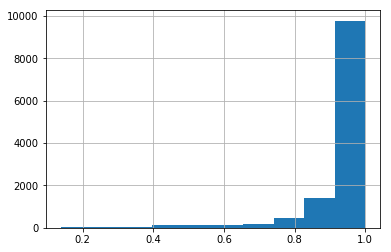

In [6]:
import difflib

difflib.SequenceMatcher(None, 'Gare de Laplace (Arcueil)', 'Arcueil Laplace RER').ratio() # 0.5
difflib.SequenceMatcher(None, 'Sucy-Bonneuil RER', 'Gare de Sucy-Bonneuil').ratio() # 0.68
difflib.SequenceMatcher(None, 'Noisy-le-Roi - Centre Commercial le Cèdre', 'Centre commercial').ratio() #0.55
difflib.SequenceMatcher(None, 'Cimetière', 'Cimetière de Saint-Maur-des-Fossés').ratio() #0.41
difflib.SequenceMatcher(None, 'A. Lebrun', 'Auguste Lebrun').ratio() #0.69
difflib.SequenceMatcher(None, 'Saint-Maur Créteil', 'SAINT-MAUR - CRETEIL RER').ratio() #0.23
difflib.SequenceMatcher(None, 'Saint-Maur Créteil'.lower(), 'SAINT-MAUR - CRETEIL RER'.lower()).ratio() #0.80
difflib.SequenceMatcher(None, 'A. Lebrun', '').ratio() #0



def compute_similarity(elem1, elem2):
    return difflib.SequenceMatcher(None, elem1.lower(), elem2.lower()).ratio()

routepoints['name_confidence'] = routepoints[['osm_name','gtfs_stop_name']].apply(lambda x: compute_similarity(*x), axis=1)
routepoints['name_confidence'].hist()



In [7]:
len(routepoints[routepoints['name_confidence'] > 0.6])

11948

11918

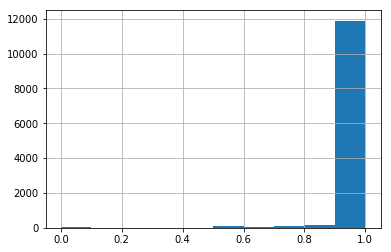

In [8]:
routepoints['line_code_confidence'] = routepoints[['osm_code','gtfs_route_short_name']].apply(lambda x: compute_similarity(*x), axis=1)
routepoints['line_code_confidence'].hist()
len(routepoints[routepoints['line_code_confidence'] > 0.8])

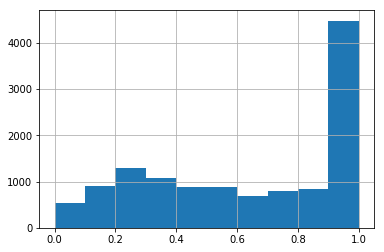

In [9]:
routepoints['destination_confidence'] = routepoints[['osm_destination','gtfs_dest_name']].apply(lambda x: compute_similarity(*x), axis=1)
routepoints['destination_confidence'].hist()

In [10]:
len(routepoints[routepoints['destination_confidence'] > 0.6])

6767

In [11]:
#tt = routepoints[routepoints['destination_confidence'] < 0.5]
#tt.to_csv('to_investigate_dest.csv')

#tt = routepoints[routepoints['name_confidence'] < 0.5]
#tt.to_csv('to_investigate_name.csv')

#tt = routepoints[routepoints['line_code_confidence'] < 0.5]
#tt.to_csv('to_investigate_line.csv')

In [12]:
routepoints = routepoints[routepoints['destination_confidence'] > 0.6]
routepoints = routepoints[routepoints['line_code_confidence'] > 0.6]
routepoints = routepoints[routepoints['name_confidence'] > 0.6]
len(osm_routepoints[osm_routepoints['osm_osm:ref:FR:STIF'] != '']) * 100.0 / len(osm_routepoints) #39 %
len(routepoints) * 100.0 / len(osm_routepoints) #quel est le pourcentage de routepoints dans OSM qu'on arrivera à utiliser

26.56070313783473

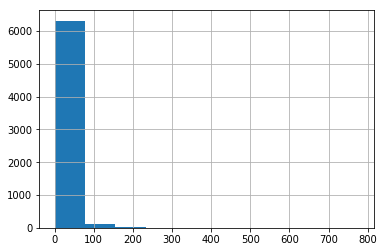

In [13]:
from geopy.distance import vincenty

def compute_distance(row):
    dist = vincenty(
        (float(row['osm_lat']), float(row['osm_lon'])), 
        (float(row['gtfs_stop_lat']), float(row['gtfs_stop_lon']))
    )
    return dist.meters
   
routepoints['distance'] = routepoints.apply(compute_distance, axis=1)

routepoints['distance'].hist()

In [14]:
len(routepoints[routepoints['distance'] > 50])

403

In [25]:
osm_routepoints[osm_routepoints['osm_osm:ref:FR:STIF'] == '9870']

,osm_stop_id,osm_name,osm_code,osm_destination,osm_network,osm_osm:ref:FR:STIF,osm_osm:ref:FR:STIF:ExternalCode_Line,osm_line_id,osm_route_id,osm_lat,osm_lon
101,StopPoint:Node:5401678640,Place Jeanne d'Arc,Licorne,Foyer Jean Rostand (Villeneuve-le-Roi),Athis Cars,9870,002002002:LIC,Line:Relation:6883314,Route:Relation:115222,48.7328185,2.4245859
150,StopPoint:Node:5401678641,Place Jeanne d'Arc,Centaure,Gare de Villeneuve-le-Roi,Athis Cars,9870,002002002:CEN,Line:Relation:6883352,Route:Relation:122930,48.732663699999996,2.4244719
17864,StopPoint:Node:5401678641,Place Jeanne d'Arc,Licorne,La Fresnaie (Villeneuve-le-Roi),Athis Cars,9870,002002002:LIC,Line:Relation:6883314,Route:Relation:6883396,48.732663699999996,2.4244719


In [24]:
routepoints[routepoints['gtfs_ZDEr_ID_REF_A'] == '9870']

,gtfs_stop_id,gtfs_route_id,gtfs_ZDEr_ID_REF_A,gtfs_stop_name,gtfs_stop_lat,gtfs_stop_lon,gtfs_wheelchair_boarding,gtfs_dest_name,gtfs_route_short_name,gtfs_agency_name,...,osm_name,osm_code,osm_destination,osm_network,osm_osm:ref:FR:STIF,osm_osm:ref:FR:STIF:ExternalCode_Line,osm_line_id,osm_route_id,osm_lat,osm_lon
0,StopPoint:4:130,002002002:CEN,9870,Jeanne d'Arc,48.73262,2.424478,,Villeneuve-le-roi Gare RER,CEN,Keolis Seine Val-De-Marne,...,Place Jeanne d'Arc,Centaure,Gare de Villeneuve-le-Roi,Athis Cars,9870,002002002:CEN,Line:Relation:6883352,Route:Relation:122930,48.732663699999996,2.4244719
3,StopPoint:4:130,002002002:LIC,9870,Jeanne d'Arc,48.73262,2.424478,,Villeneuve-le-roi Gare RER,LIC,Keolis Seine Val-De-Marne,...,Place Jeanne d'Arc,Licorne,Foyer Jean Rostand (Villeneuve-le-Roi),Athis Cars,9870,002002002:LIC,Line:Relation:6883314,Route:Relation:115222,48.7328185,2.4245859
4,StopPoint:4:130,002002002:LIC,9870,Jeanne d'Arc,48.73262,2.424478,,Villeneuve-le-roi Gare RER,LIC,Keolis Seine Val-De-Marne,...,Place Jeanne d'Arc,Licorne,La Fresnaie (Villeneuve-le-Roi),Athis Cars,9870,002002002:LIC,Line:Relation:6883314,Route:Relation:6883396,48.732663699999996,2.4244719
5,StopPoint:4:130,002002002:LIC,9870,Jeanne d'Arc,48.73262,2.424478,,Foyer Jean Rostand,LIC,Keolis Seine Val-De-Marne,...,Place Jeanne d'Arc,Licorne,Foyer Jean Rostand (Villeneuve-le-Roi),Athis Cars,9870,002002002:LIC,Line:Relation:6883314,Route:Relation:115222,48.7328185,2.4245859
6,StopPoint:4:130,002002002:LIC,9870,Jeanne d'Arc,48.73262,2.424478,,Foyer Jean Rostand,LIC,Keolis Seine Val-De-Marne,...,Place Jeanne d'Arc,Licorne,La Fresnaie (Villeneuve-le-Roi),Athis Cars,9870,002002002:LIC,Line:Relation:6883314,Route:Relation:6883396,48.732663699999996,2.4244719


In [ ]:
# on constate bien que le merge ne prend pas que le premier : ici il y a deux occurrences dans OSM avec les deux mêmes codes, on a donc 4 lignes dans le fichier fusionné